In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error, explained_variance_score
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pickle



from regressors import stats
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_csv('cmm_erdos_2022/pharmacy_tx.csv')

In [3]:
data = data[data.rejected == False] # we are not taking rejected claims

# splitting data

train,test= train_test_split(data,test_size=0.2)

In [7]:
train_temp=train
test_temp=test

We are going to do feature engineering and introduce new features in our data. Here we introduce 7 features `p1`,...,`p7` by aggregating over various columns.

In [8]:
temp = train_temp.groupby(['drug','pharmacy','bin'],as_index=False).patient_pay.mean()
temp['p1'] = temp['patient_pay']
del temp['patient_pay']

train_temp = pd.merge(train_temp,temp,on=['drug','pharmacy','bin'], how='left')

test_temp = pd.merge(test_temp,temp,on=['drug','pharmacy','bin'], how='left')


temp = train_temp.groupby(['drug','pharmacy','group'],as_index=False).patient_pay.mean()
temp['p2'] = temp['patient_pay']
del temp['patient_pay']

train_temp = pd.merge(train_temp,temp,on=['drug','pharmacy','group'], how='left')
train_temp['p2']=train_temp['p2'].fillna(train_temp['p1'])

test_temp = pd.merge(test_temp,temp,on=['drug','pharmacy','group'], how='left')

temp = train_temp.groupby(['drug','pharmacy','diagnosis'],as_index=False).patient_pay.mean()
temp['p3'] = temp['patient_pay']
del temp['patient_pay']

train_temp = pd.merge(train_temp,temp,on=['drug','pharmacy','diagnosis'], how='left')

test_temp = pd.merge(test_temp,temp,on=['drug','pharmacy','diagnosis'], how='left')



temp = train_temp.groupby(['drug','pharmacy'],as_index=False).patient_pay.mean()
temp['p4'] = temp['patient_pay']
del temp['patient_pay']

train_temp = pd.merge(train_temp,temp,on=['drug','pharmacy'], how='left')

test_temp = pd.merge(test_temp,temp,on=['drug','pharmacy'], how='left')

temp = train_temp.groupby(['drug','pharmacy','pcn'],as_index=False).patient_pay.mean()
temp['p5'] = temp['patient_pay']
del temp['patient_pay']

train_temp = pd.merge(train_temp,temp,on=['drug','pharmacy','pcn'], how='left')
train_temp['p5']=train_temp['p5'].fillna(train_temp['p1'])

test_temp = pd.merge(test_temp,temp,on=['drug','pharmacy','pcn'], how='left')

temp = train_temp.groupby(['drug','diagnosis'],as_index=False).patient_pay.mean()
temp['p6'] = temp['patient_pay']
del temp['patient_pay']

train_temp = pd.merge(train_temp,temp,on=['drug','diagnosis'], how='left')
test_temp = pd.merge(test_temp,temp,on=['drug','diagnosis'], how='left')

temp = train_temp.groupby(['drug','pcn'],as_index=False).patient_pay.median()
temp['p7'] = temp['patient_pay']
del temp['patient_pay']

train_temp = pd.merge(train_temp,temp,on=['drug','pcn'], how='left')

test_temp = pd.merge(test_temp,temp,on=['drug','pcn'], how='left')

temp = train_temp.groupby(['drug','group'],as_index=False).patient_pay.median()
temp['p8'] = temp['patient_pay']
del temp['patient_pay']

train_temp = pd.merge(train_temp,temp,on=['drug','group'], how='left')

test_temp = pd.merge(test_temp,temp,on=['drug','group'], how='left')


<AxesSubplot:>

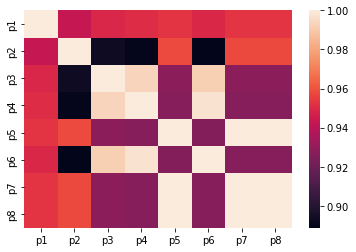

In [15]:
train_temp['p7']=train_temp['p7'].fillna(train_temp['p1'])
train_temp['p8']=train_temp['p7'].fillna(train_temp['p1'])

train_temp2=train_temp[['p1','p2','p3','p4','p5','p6','p7','p8']]
train_temp2=train_temp2.drop_duplicates()
#train_temp2.to_csv('feature_train.csv',index=False)

sns.heatmap(train_temp2.corr())  #checking correlation among features

<AxesSubplot:>

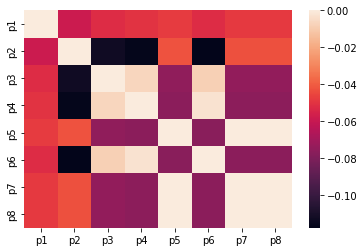

In [16]:
sns.heatmap(np.log(train_temp2.corr())) # transformation changes linear correlation

In [17]:
train_temp2=train_temp[['p1','p2','p3','p4','p5','p6','p7','p8','patient_pay']]

X_train=train_temp2[['p1','p2','p3','p4','p5','p6','p7','p8']]
y_train=train_temp2['patient_pay']

# checking how many empty entries we have in test set
print(test_temp.isna().sum())

# imputing the test data with other non-null entries
test_temp['p1']=test_temp['p1'].fillna(test_temp['p6'])
test_temp['p2']=test_temp['p2'].fillna(test_temp['p1'])
test_temp['p3']=test_temp['p3'].fillna(test_temp['p1'])
test_temp['p5']=test_temp['p5'].fillna(test_temp['p1'])
test_temp['p7']=test_temp['p7'].fillna(test_temp['p1'])
test_temp['p8']=test_temp['p7'].fillna(test_temp['p1'])


X_test=test_temp[['p1','p2','p3','p4','p5','p6','p7','p8']]
y_test=test_temp['patient_pay']

tx_date             0
pharmacy            0
diagnosis           0
drug                0
bin                 0
pcn            664810
group          725277
rejected            0
patient_pay         0
p1                 43
p2             725477
p3                 15
p4                  0
p5             665028
p6                  0
p7             664811
p8             725277
dtype: int64


In [24]:
#Ridge Regression on training set

lreg = Ridge(alpha=1e3)
lreg.fit(np.log(X_train),np.log(y_train))

train_predict = np.exp(lreg.predict(np.log(X_train)))

print(r2_score(train_predict,y_train))
print(mean_absolute_error(train_predict,y_train))
print(mean_squared_error(train_predict,y_train))

#stats.summary(lreg,np.log(X_train),np.log(y_train))
lreg.coef_

0.9826089338320936
1.8361703768330906
27.91697972042571


array([-3.14349265e-01,  8.05610652e-01,  7.60516416e-02, -3.04697577e-02,
        2.77690359e-01,  5.99737061e-04,  9.46142223e-02,  9.46142223e-02])

In [25]:

# ridge predictions on test data

pred = np.power((lreg.predict(np.sqrt(X_test))),2)

print(r2_score(pred,y_test))
print(mean_absolute_error(pred,y_test))
print(mean_squared_error(pred,y_test))

0.9830751755260282
1.8775670287233805
26.834351265391515


In [26]:
test_temp['pred']=pred

# test entries where we have an error by more than $50

test_temp[(abs(test_temp.patient_pay - test_temp.pred)>50)]

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,p1,p2,p3,p4,p5,p6,p7,p8,pred
413,2022-09-10,Pharmacy #53,Z20.23,branded flacelfatastat,322463,3O71UTS,NaN,False,242.17,135.495691,135.495691,189.367065,190.395953,242.17,205.143244,241.37,241.37,185.028445
931,2022-12-17,Pharmacy #16,P79.51,branded prefluflomycin,691847,N098KI,6SP1DG,False,311.03,182.654615,311.030000,293.418667,225.681016,311.03,261.523922,309.62,309.62,362.111794
1167,2022-02-26,Pharmacy #19,U75.95,branded monemodiase,96934,S76J7V6,NaN,False,489.97,385.474444,385.474444,420.715784,421.810829,489.97,403.983150,490.52,490.52,437.531526
1769,2022-04-11,Pharmacy #0,B45.03,branded monemodiase,691847,ZQPX,KZWQDIHCLLHD1,False,553.91,385.506875,553.910000,333.186176,354.045017,553.91,405.933977,554.72,554.72,604.948246
1987,2022-06-10,Pharmacy #5,Z20.23,branded flacelfatastat,322463,YICC41,MP3IQ,False,257.32,103.311270,257.320000,200.198728,199.273811,257.32,205.143244,257.32,257.32,318.996630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2561176,2022-05-28,Pharmacy #29,Z20.23,branded flacelfatastat,322463,3O71UTS,NaN,False,241.23,134.168557,134.168557,201.539145,199.783005,241.23,205.143244,241.37,241.37,184.658716
2561445,2022-11-15,Pharmacy #40,U06.52,branded tugesutin,322463,3O71UTS,NaN,False,198.19,95.659226,95.659226,150.474063,163.982166,198.19,158.279600,198.04,198.04,141.979528
2562676,2022-04-10,Pharmacy #19,C14.36,branded prefluflomycin,322463,3O71UTS,NaN,False,191.62,86.502000,86.502000,270.206832,244.697434,191.62,233.702561,191.62,191.62,139.317694
2563333,2022-08-11,Pharmacy #3,Q72.66,branded tugesutin,322463,3Y5ZW0,NaN,False,210.39,103.298926,103.298926,175.420243,166.884899,210.39,161.720875,210.18,210.18,153.106944


In [27]:
train_temp2=train_temp2.drop_duplicates() #dropping duplicates to run models fater
train_temp2.shape

(473979, 9)

In [28]:
X_train=train_temp2[['p1','p2','p3','p4','p5','p6','p7','p8']]
y_train=train_temp2['patient_pay']
X_test=test_temp[['p1','p2','p3','p4','p5','p6','p7','p8']]


lreg = Ridge(alpha=1e3)
lreg.fit(np.log(X_train),np.log(y_train))

train_predict = np.exp(lreg.predict(np.log(X_train)))

print('Train predictions')

print(r2_score(train_predict,y_train))
print(mean_absolute_error(train_predict,y_train))
print(mean_squared_error(train_predict,y_train))
print()

print('Test predictions')

pred = np.exp(lreg.predict(np.log(X_test)))

print(r2_score(pred,y_test))
print(mean_absolute_error(pred,y_test))
print(mean_squared_error(pred,y_test))

#stats.summary(lreg,np.log(X_train),np.log(y_train))
print(lreg.coef_)

test_temp['pred']=pred

test_temp[(abs(test_temp.patient_pay - test_temp.pred)>50)]

Train predictions
0.9724337019079161
4.499156899961111
93.89931516262058

Test predictions
0.9821965044971048
2.2708141308949408
31.354806568617928
[-0.23649938  0.729809    0.07017046 -0.04786242  0.50589058  0.00985355
 -0.00869073 -0.00869073]


,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,p1,p2,p3,p4,p5,p6,p7,p8,pred
286,2022-02-10,Pharmacy #51,C14.36,branded prefluflomycin,664344,TPJD,NaN,False,181.48,280.765111,280.765111,229.941240,241.575784,181.48,233.702561,180.80,180.80,240.133316
931,2022-12-17,Pharmacy #16,P79.51,branded prefluflomycin,691847,N098KI,6SP1DG,False,311.03,182.654615,311.030000,293.418667,225.681016,311.03,261.523922,309.62,309.62,380.790153
1769,2022-04-11,Pharmacy #0,B45.03,branded monemodiase,691847,ZQPX,KZWQDIHCLLHD1,False,553.91,385.506875,553.910000,333.186176,354.045017,553.91,405.933977,554.72,554.72,639.248666
1987,2022-06-10,Pharmacy #5,Z20.23,branded flacelfatastat,322463,YICC41,MP3IQ,False,257.32,103.311270,257.320000,200.198728,199.273811,257.32,205.143244,257.32,257.32,337.890397
2500,2022-10-12,Pharmacy #23,U75.95,branded monemodiase,322463,3O71UTS,NaN,False,307.37,173.603043,173.603043,384.019115,389.999540,307.37,403.983150,306.73,306.73,249.601050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2561924,2022-03-09,Pharmacy #40,U75.95,branded monemodiase,322463,393U,XY5GQQ9,False,306.75,220.158725,306.750000,402.430913,405.710776,306.75,403.983150,306.75,306.75,357.631279
2562676,2022-04-10,Pharmacy #19,C14.36,branded prefluflomycin,322463,3O71UTS,NaN,False,191.62,86.502000,86.502000,270.206832,244.697434,191.62,233.702561,191.62,191.62,139.435008
2563333,2022-08-11,Pharmacy #3,Q72.66,branded tugesutin,322463,3Y5ZW0,NaN,False,210.39,103.298926,103.298926,175.420243,166.884899,210.39,161.720875,210.18,210.18,156.833551
2563453,2022-03-26,Pharmacy #20,B45.03,branded masonic,322463,393U,XY5GQQ9,False,147.98,47.781905,147.980000,207.365764,209.369933,147.98,203.672467,148.02,148.02,206.662457


In [29]:
rf = RandomForestRegressor(max_depth=10,max_features=5,verbose=1,n_jobs=2)

rf.fit(X_train,y_train)

pred_train = rf.predict(X_train)

print(r2_score(pred_train,y_train))
print(mean_absolute_error(pred_train,y_train))
print(mean_squared_error(pred_train,y_train))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   24.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   54.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s


0.9875297226915142
2.947874029514546
39.95581787903374


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.1s finished


In [30]:
# predictions
pred = rf.predict(X_test)

print(r2_score(pred,y_test))
print(mean_absolute_error(pred,y_test))
print(mean_squared_error(pred,y_test))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.4s


0.9923428074559812
1.5385563629478047
13.168019907638792


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    9.6s finished


In [31]:
test_temp['pred']=pred

# entries where our predictions are off by $50

test_temp[(abs(test_temp.patient_pay - test_temp.pred)>50)]

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,p1,p2,p3,p4,p5,p6,p7,p8,pred
73401,2022-08-09,Pharmacy #26,Z20.23,branded vivafastat,757349,MSCXSG,DGLGRYP,False,227.62,175.724000,174.500000,147.756810,151.294076,174.500000,150.816152,175.570000,175.570000,176.778891
100233,2022-10-11,Pharmacy #54,K87.68,branded cuxirin,322463,YICC41,MP3IQ,False,102.06,21.579140,21.579140,67.811936,69.457872,21.579140,71.842577,100.840000,100.840000,44.788903
113612,2022-10-31,Pharmacy #57,Z20.23,branded flacelfatastat,322463,3Y5ZW0,NaN,False,244.98,16.410000,16.410000,211.543403,211.661158,16.410000,205.143244,245.780000,245.780000,24.727166
169671,2022-02-04,Pharmacy #22,Z20.23,branded flacelfatastat,756120,7THOQ5,NaN,False,321.12,246.240000,246.240000,224.404175,223.633712,246.240000,205.143244,246.660000,246.660000,248.184107
191296,2022-09-20,Pharmacy #4,E30.01,branded nenizevir,322463,T52GV,EVD4X5,False,16.29,78.039828,78.039828,75.586667,75.586667,78.039828,78.039828,16.290000,16.290000,78.200154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513457,2022-02-27,Pharmacy #11,Z20.23,branded flacelfatastat,725700,327CKV,IOEAN1DWVV3Y,False,321.12,265.960000,267.160000,187.641415,193.086745,267.160000,205.143244,266.730000,266.730000,267.701334
2522667,2022-01-10,Pharmacy #39,U06.52,branded tugesutin,725700,NaN,DYGBI610ZY,False,254.20,203.927405,191.877419,156.625422,167.935090,203.927405,158.279600,203.927405,203.927405,200.387943
2533467,2022-10-19,Pharmacy #36,B45.03,branded pranic,664344,NaN,YY6B1J4E8KJ3,False,110.21,197.955882,110.210000,190.410860,193.910721,197.955882,168.587400,197.955882,197.955882,165.815544
2556782,2022-01-08,Pharmacy #26,L85.13,branded vivafastat,757349,MSCXSG,DGLGRYP,False,227.62,175.724000,174.500000,179.977959,151.294076,174.500000,152.156527,175.570000,175.570000,176.778891


In [32]:
rf.feature_importances_

array([1.49308047e-03, 5.30952555e-01, 1.82013868e-04, 4.89987961e-04,
       2.56298722e-01, 1.14740423e-03, 1.26741058e-01, 8.26951785e-02])

In [33]:
test_temp.sample(10)

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,p1,p2,p3,p4,p5,p6,p7,p8,pred
238411,2022-12-19,Pharmacy #12,G99.93,branded tanoclolol,664344,TPJD,NaN,False,19.82,14.382365,14.382365,13.530577,13.501066,19.820000,13.166190,19.820000,19.820000,19.967518
584851,2022-08-07,Pharmacy #55,M42.24,branded semufolic,322463,3O71UTS,NaN,False,27.93,23.857496,23.857496,50.350471,44.908862,27.930000,43.255383,26.580000,26.580000,28.804549
925871,2022-08-15,Pharmacy #4,C36.99,branded gosate,664344,DY4B,NaN,False,103.03,61.683585,61.683585,89.796809,73.879186,103.030000,84.161423,103.100000,103.100000,104.527491
1661964,2022-05-13,Pharmacy #16,I68.27,branded hidizuzunib,96934,S76J7V6,NaN,False,82.77,77.557167,77.557167,72.039252,72.283514,83.587178,70.441962,81.470000,81.470000,88.093381
1624097,2022-07-02,Pharmacy #43,Q72.66,branded tugesutin,664344,TAZ5W,T51T6V2E8L,False,202.19,150.510584,202.190000,166.039330,163.499249,202.190000,161.720875,201.670000,201.670000,203.642864
923426,2022-04-11,Pharmacy #44,U60.52,generic foxivelule,664344,NaN,STGRDKR1J5RD,False,5.95,12.861116,5.950000,9.572746,9.546072,12.861116,9.114057,12.861116,12.861116,6.011596
2165663,2022-12-22,Pharmacy #38,I68.27,branded hidizuzunib,757349,RM0HB,SJVO3GXUURRGO,False,61.15,79.355935,61.150000,66.605783,66.344526,61.150000,70.441962,61.430000,61.430000,62.036172
199797,2022-02-04,Pharmacy #30,Q85.91,branded glycontazepelol,664344,NaN,STGRDKR1J5RD,False,10.77,11.219272,10.770000,12.218025,12.237425,11.219272,12.657873,11.219272,11.219272,11.030355
861134,2022-06-14,Pharmacy #43,G99.93,branded tanoclolol,725700,1UQC,NaN,False,13.39,13.082650,13.082650,13.222037,12.865463,13.390000,13.166190,13.390000,13.390000,13.692903
2177681,2022-06-03,Pharmacy #53,H36.57,branded tocilic,664344,W1LW9Y,0OGKQ,False,22.51,27.139351,26.107818,24.296615,24.252935,26.107818,24.278568,21.710000,21.710000,34.913777


We now try Gradient Boost Model to actually interval range for each predictions.

In [36]:
# Set lower and upper quantile
LOWER_ALPHA = 0.2
UPPER_ALPHA = 0.9
# Each model has to be separate
lower_model = GradientBoostingRegressor(loss="quantile",                   
                                        alpha=LOWER_ALPHA)
# The mid model will use the default loss
mid_model = GradientBoostingRegressor(loss="ls")
upper_model = GradientBoostingRegressor(loss="quantile",
                                        alpha=UPPER_ALPHA)

In [37]:
# Fit models

lower_model.fit(X_train, y_train)
mid_model.fit(X_train, y_train)
upper_model.fit(X_train, y_train)

# fitting these models take a lot of time; so we are going to save these models for later use.


/Users/mitabanik/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


In [38]:
#saving these models
file1='lower_model.sav'
file2='mid_model.sav'
file3='upper_model.sav'

pickle.dump(lower_model, open(file1, 'wb'))
pickle.dump(mid_model, open(file2, 'wb'))
pickle.dump(upper_model, open(file3, 'wb'))

In [40]:
#loading models using pickle
mid_model=pickle.load(open('mid_model.sav','rb'))
upper_model=pickle.load(open('upper_model.sav','rb'))
lower_model=pickle.load(open('lower_model.sav','rb'))

predictions = pd.DataFrame(y_test)

predictions['lower'] = lower_model.predict(X_test)
predictions['mid'] = mid_model.predict(X_test)
predictions['upper'] = upper_model.predict(X_test)

print('Explained variance due to each model :')

print('Lower range ', r2_score(predictions['lower'],y_test))
print('Actual Predictions', r2_score(predictions['mid'],y_test))
print('Upper range ',r2_score(predictions['upper'],y_test))

print()

print('MAEs due to each model :')

print('Lower range ', mean_absolute_error(predictions['lower'],y_test))
print('Actual Predictions', mean_absolute_error(predictions['mid'],y_test))
print('Upper range ',mean_absolute_error(predictions['upper'],y_test))

print()

print('MSEs due to each model :')

print('Lower range ', mean_squared_error(predictions['lower'],y_test))
print('Actual Predictions', mean_squared_error(predictions['mid'],y_test))
print('Upper range ',mean_squared_error(predictions['upper'],y_test))

print()


Explained variance due to each model :
Lower range  0.7528402631284549
Actual Predictions 0.9905762158737645
Upper range  0.9261868856228906

MAEs due to each model :
Lower range  2.767220569621712
Actual Predictions 2.0583188534043866
Upper range  7.01747946849938

MSEs due to each model :
Lower range  245.74914924768194
Actual Predictions 16.043468521382234
Upper range  158.7044188027045



The `mid-model` performs a little worse than the RandomForest Model; but the results are comparable. The lower and upper model gives a range of values we can expect the actual patient-pay to be.

In [43]:
predictions.sample(10)

,patient_pay,lower,mid,upper
2325036,48.98,49.257015,51.765183,71.140323
2052253,49.79,49.257015,53.336587,76.063271
502563,18.16,12.483298,15.810037,17.949208
983655,8.21,8.002789,8.480712,8.599887
612879,18.16,11.548713,15.270765,18.510430
1567923,17.11,14.635788,15.204847,17.044548
1091415,56.40,58.220440,65.953912,85.828514
1492339,6.11,5.982415,7.230344,10.236510
1235077,7.97,7.694975,8.223947,8.599887
455562,13.39,13.389592,13.946608,14.399981


In [50]:
predictions[predictions['patient_pay']-predictions['lower']<-10]

,patient_pay,lower,mid,upper
5120,71.95,82.871800,104.511678,123.258080
15444,73.27,110.648382,116.399615,134.419980
32501,64.28,74.724992,87.690436,124.952490
37959,64.62,75.047648,93.353544,131.236493
58892,29.69,43.021731,46.408162,56.828060
...,...,...,...,...
2532550,64.28,74.724992,87.690436,124.952490
2537823,64.56,74.724992,87.668399,124.952490
2554745,65.67,81.093541,92.326863,117.018940
2560281,152.72,172.182729,185.998156,210.564659


In [69]:
temp = train_temp.groupby(['drug','pharmacy','group'],as_index=False).patient_pay.max()
temp['without_deduct'] = temp['patient_pay']
del temp['patient_pay']

train_temp = pd.merge(train_temp,temp,on=['drug','pharmacy','group'], how='left')

test_temp = pd.merge(test_temp,temp,on=['drug','pharmacy','group'], how='left')

In [70]:
temp = train_temp.groupby(['drug','pharmacy','group'],as_index=False).patient_pay.min()
temp['with_deduct'] = temp['patient_pay']
del temp['patient_pay']

train_temp = pd.merge(train_temp,temp,on=['drug','pharmacy','group'], how='left')

test_temp = pd.merge(test_temp,temp,on=['drug','pharmacy','group'], how='left')

In [71]:
train_temp[train_temp['without_deduct']>train_temp['with_deduct']]

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,p1,p2,p3,p4,p5,p6,p7,p8,diff_pay,without_deduct,with_deduct
30,2022-06-21,Pharmacy #44,K87.68,generic vocopirin,956971,WM6A,L9QZA,False,10.23,10.869130,10.869130,14.066095,14.146472,10.869130,13.503093,9.010000,9.010000,58.191126,17.58,10.23
40,2022-04-20,Pharmacy #8,Q72.66,generic ratin,571569,KB38N,6BYJBW,False,15.49,16.500000,16.557170,16.027620,16.044853,16.557170,15.864952,15.670000,15.670000,48.941548,31.65,15.49
52,2022-02-02,Pharmacy #14,Q72.66,generic ratin,725700,327CKV,IOEAN1DWVV3Y,False,30.31,16.663478,18.277703,15.857641,15.880816,18.277703,15.864952,16.520000,16.520000,52.589904,30.31,15.94
54,2022-08-17,Pharmacy #36,H36.57,branded tocilic,725700,327CKV,IOEAN1DWVV3Y,False,24.82,26.006107,28.825276,25.113428,24.859502,28.825276,24.278568,24.080000,24.080000,46.698024,53.15,24.82
78,2022-12-22,Pharmacy #42,V80.87,branded cycloxasonol,725700,327CKV,IOEAN1DWVV3Y,False,22.33,21.976236,23.834352,22.238985,22.401725,23.834352,21.370044,21.840000,21.840000,49.033816,45.54,22.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10258659,2022-06-04,Pharmacy #51,I68.27,branded mule,725700,NaN,DYGBI610ZY,False,36.84,41.437710,38.425455,37.177988,37.307932,41.437710,36.455338,41.437710,41.437710,NaN,54.28,36.84
10258662,2022-09-23,Pharmacy #23,Z66.42,branded diadaric,322463,NaN,0TZ9XYJZJH,False,146.43,88.308524,147.109265,122.317629,122.532954,88.308524,124.670429,88.308524,88.308524,NaN,192.62,146.43
10258671,2022-05-08,Pharmacy #31,E49.13,generic lixegimoric,725700,327CKV,IOEAN1DWVV3Y,False,14.67,19.517959,20.301818,14.086464,14.184548,20.301818,14.578566,15.640000,15.640000,54.212860,27.06,14.67
10258673,2022-10-06,Pharmacy #31,G51.87,branded hidizuzunib,664344,BIZF,QK6BI1N61,False,91.06,58.634394,91.546757,69.292138,68.670976,91.546757,70.164250,91.630000,91.630000,83.487668,109.07,91.06


In [73]:
# how much percent of money a customer end up paying after deductable kicks in?
# 100 means you pay the same amount as it was before deuctible and 0 means after dedeuctible kicks in you don't pay anything for the drug
train_temp['diff_pay']=(train_temp['with_deduct']/train_temp['without_deduct'])*100

In [76]:
train_temp[['with_deduct','without_deduct','diff_pay']].sample(10)

,with_deduct,without_deduct,diff_pay
8317544,10.72,10.72,100.000000
450469,15.47,15.47,100.000000
1391802,10.00,10.00,100.000000
10023519,26.38,26.38,100.000000
9600654,NaN,NaN,NaN
4119082,111.19,111.19,100.000000
3666200,10.72,10.72,100.000000
1984093,10.56,10.56,100.000000
3798237,15.07,23.88,63.107203
5559913,33.37,39.90,83.634085


In [80]:
temp = train_temp[['drug','bin','with_deduct','without_deduct','diff_pay']]
temp=temp.drop_duplicates()


tt=temp.groupby(['drug','bin',],as_index=False).diff_pay.mean()

tt=tt.drop_duplicates()
tt= tt.pivot('drug','bin')

tt[:50]


diff_pay                                             \
bin                       96934  160389      322463      539437      571569   
drug                                                                          
branded antimab            100.0  100.0   77.716404   65.047878   69.752481   
branded bovirol            100.0  100.0  100.000000  100.000000  100.000000   
branded brede              100.0  100.0  100.000000  100.000000  100.000000   
branded choxestamenium     100.0  100.0   95.156284   90.642062   90.672221   
branded cibroniudosin      100.0  100.0  100.000000  100.000000  100.000000   
branded cicrochoric        100.0  100.0   85.002639   76.317285   63.964093   
branded colade             100.0  100.0  100.000000  100.000000  100.000000   
branded colifunene         100.0  100.0   99.856725  100.000000  100.000000   
branded cupitelol          100.0  100.0  100.000000  100.000000  100.000000   
branded cuxirin            100.0  100.0   96.357007   92.973844   61.662815   
branded cycloxasonol       100.0  100.0   81.374922   71.652053   69.144244   
branded debome             100.0  100.0   96.992381   91.962499   95.280979   
branded devacin            100.0  100.0   95.577867   93.208578   94.153059   
branded diadaric           100.0  100.0   93.050325   88.640157   82.358655   
branded dienulol           100.0  100.0  100.000000  100.000000  100.000000   
branded dusin              100.0  100.0   90.041372   93.833333   90.876471   
branded fazipilin          100.0  100.0   94.822762   92.226214   82.587687   
branded flacelfatastat     100.0  100.0   96.457476  100.000000  100.000000   
branded flalurin           100.0  100.0   95.694642   92.457347   93.504497   
branded foxivelule         100.0  100.0  100.000000  100.000000  100.000000   
branded fumiluric          100.0  100.0   89.524954   92.841007   92.205085   
branded genetramycicin     100.0  100.0   97.866677   97.396877   96.407762   
branded gentipapavir       100.0  100.0   98.085045   95.295684   97.091772   
branded glulune            100.0  100.0   85.382795   88.548796   72.665327   
branded glycogane          100.0  100.0   96.634415   92.771169   93.948391   
branded glycontazepelol    100.0  100.0  100.000000  100.000000  100.000000   
branded gohevitravir         NaN  100.0  100.000000  100.000000  100.000000   
branded gorol              100.0  100.0  100.000000  100.000000  100.000000   
branded gosate             100.0  100.0   88.294552   94.419899   95.309855   
branded hidizuzunib        100.0  100.0   94.697956   90.807428   87.929151   
branded hivir              100.0  100.0  100.000000  100.000000  100.000000   
branded hozirol            100.0  100.0  100.000000  100.000000  100.000000   
branded isobrovelin        100.0  100.0   88.442933   63.457493   63.088455   
branded kediborin          100.0  100.0   88.789518   82.836447   96.108629   
branded keglusited         100.0  100.0  100.000000  100.000000  100.000000   
branded lalol              100.0  100.0  100.000000  100.000000  100.000000   
branded lehydrome            NaN  100.0   96.987036   90.826201   97.739493   
branded lixegimoric        100.0  100.0   85.367726   82.309510   75.289575   
branded mamate             100.0  100.0   95.249013   90.275908   84.303888   
branded masonic            100.0  100.0   99.205939  100.000000  100.000000   
branded momudobatin        100.0  100.0   96.728580   94.994473   95.116328   
branded monemodiase        100.0  100.0  100.000000  100.000000  100.000000   
branded mule               100.0  100.0   88.355900  100.000000   81.676650   
branded nenizevir            NaN  100.0  100.000000   96.706043   98.203772   
branded nephelilin         100.0  100.0   94.447196   90.635049   89.428445   
branded nicotilin          100.0  100.0   84.691182   95.755493   66.161129   
branded notin              100.0  100.0   95.173004   93.223436   93.712268   
branded nusudaric          100.0  100.0   93.607828   79.149271   86.57208

Conclusions: Some insurance companies have fixed drug prices(these are the one where we see all `100 percent`) and they have $0 deductible; so all the prices of the drugs remain fixed. 


In [83]:
temp = train_temp[['drug','bin','with_deduct','without_deduct','diff_pay']]
temp=temp.drop_duplicates()


tt=temp.groupby(['drug','bin',],as_index=False).with_deduct.mean()

tt=tt.drop_duplicates()
tt= tt.pivot('drug','bin')

tt[:50]

with_deduct                                      \
bin                          96934       160389      322463      539437   
drug                                                                      
branded antimab               10.02   20.684490   24.625621   24.654603   
branded bovirol               12.63   12.540000   13.678333    7.270000   
branded brede                 12.80   18.639333   12.795000   15.470000   
branded choxestamenium        19.74  132.174000  148.804741  116.955373   
branded cibroniudosin          9.10   12.540000   11.414000   15.470000   
branded cicrochoric            6.20   19.038108   16.277414   22.346863   
branded colade                 9.69   12.540000   10.415000    7.270000   
branded colifunene            10.02   21.259375   19.635614   15.470000   
branded cupitelol              9.44   12.540000   12.951667   15.470000   
branded cuxirin               19.74   89.689500   90.491446  100.033333   
branded cycloxasonol          19.74   21.303830   20.134651   26.195862   
branded debome                19.74  135.106333  106.612000  103.373864   
branded devacin               19.74  132.003333  137.541000  148.834324   
branded diadaric              19.74  152.742245  142.237303  166.671781   
branded dienulol               9.75   12.540000   13.155000   15.470000   
branded dusin                 19.74   41.906000   30.693529   42.098571   
branded fazipilin             19.74   76.734694  100.602541  111.047639   
branded flacelfatastat        19.74  239.284054  242.501918  253.095417   
branded flalurin              19.74   78.469524   82.123333   86.028246   
branded foxivelule             7.91   12.540000    8.788333   15.470000   
branded fumiluric             19.74   36.053077   35.818696   38.989412   
branded genetramycicin        19.74  166.301852  132.234595  177.080000   
branded gentipapavir          19.74   80.968485   67.788182   88.673061   
branded glulune                6.20   10.807143   12.349080   14.909630   
branded glycogane             19.74   76.168182   71.131341   83.563548   
branded glycontazepelol        7.07   12.540000   12.123333   15.470000   
branded gohevitravir            NaN   19.025000   14.844000   15.470000   
branded gorol                  7.35   12.540000   10.321667   15.470000   
branded gosate                19.74   98.821290   76.586750   80.841351   
branded hidizuzunib           19.74   79.994808   71.440674   94.809437   
branded hivir                 10.02   20.441136   18.290000   22.276957   
branded hozirol               11.54   12.540000   13.530000   15.470000   
branded isobrovelin           10.02   39.002273   31.824112   29.075161   
branded kediborin             10.02   50.735238   34.206164   55.272333   
branded keglusited            10.02   19.936364   18.871957   22.284898   
branded lalol                  6.13   12.540000   11.971667    7.270000   
branded lehydrome               NaN   73.192500   62.058571   42.170000   
branded lixegimoric            6.20   15.328750   14.457170   18.888000   
branded mamate                10.02   53.248387   59.410000   62.818140   
branded masonic               19.74  232.799375  224.579600  258.833600   
branded momudobatin           19.74   61.230816   61.681606   68.130328   
branded monemodiase           19.74  500.056364  464.746964  524.166809   
branded mule                  19.74   47.524808   37.878541   28.442400   
branded nenizevir               NaN   80.235000   57.358000   96.842500   
branded nephelilin            19.74   98.707273  112.844860  117.940758   
branded nicotilin             19.74   61.974324   51.703784   73.908103   
branded notin                 19.74  130.772973  120.881143   98.008793   
branded nusudaric             19.74  150.335306  154.784694   76.779861   
branded oxasoted               6.68   12.540000   11.125000    7.270000   
branded pheromycin            19.74  435.123077  337.699412  456.597000   

                                                